    
## Capstone Project 2
1. [Data Preparation](#Data-Prep)
2. [Visualization](#Visualization)
   1. [Visualizing Images](#Vis-Imgs)
   2. [Image Segmentation](#Img-Seg)
3. [Multilayer Neural Network](#Neural-Network)
   1. [Hyperparameter Tuning](#Tuning)
4. [Convolutional Neural Network](#CNN)
   1. [Image Augmentation](#Img-Aug)
   2. [KFold Cross-Validation](#cv)
5. [Classification Report](#Report)
6. [Visualizing Intermediate Layers](#Intermediate-Layers)

In [148]:
import numpy as np
import pandas as pd
import random
import pathlib
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import keras
from keras import optimizers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ShuffleSplit


The MNIST database (**Modified National Institute of Standards and Technology database**) is a database of handwritten digits that is commonly used for training various image processing systems.


Recently, Zalando Research has released a new class of MNIST, called **Fashion-MNIST** dataset which intended to serve as a direct replacement for the original MNIST to benchmark machine learning algorithms.  It is consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

The data source can be found [here](http://yann.lecun.com/exdb/mnist/)


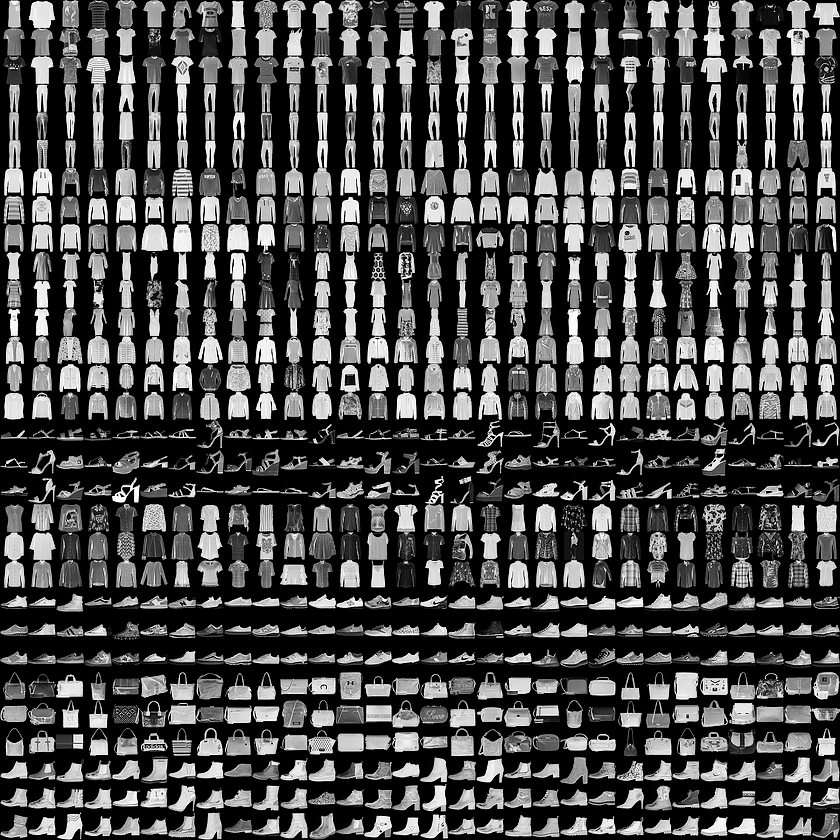

In [149]:
display(Image.open('data/fashion-mnist-sprite.png'))


## 1. Data Preparation  <a class="anchor" id="Data-Prep"></a>

In [150]:
df_train = pd.read_csv('data/fashion-mnist_train.csv')
df_test = pd.read_csv('data/fashion-mnist_test.csv')

In [151]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [152]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [153]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`df_train`and `df_test` dataframes represent train and test datasets whoes ecah 60,000 and 10,000 rows indicates one image. 
Each image has 784 pixels (28 pixels in height and 28 pixels in width), and has a single pixel-value associated with it, indicating the lightness or darkness of that pixel. The pixel-values are integer numbers between 0 and 255 stored in columns 2 to 785. The first column corresponds to the class label of images. The labels are coded by 0 to 9 for 10 categories of fashion items.

`df_label` shows the description of labels.

In [154]:
items = {'Label':[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
        'Description':['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']} 
df_label = pd.DataFrame(items).set_index('Label')
df_label.head(10)



,Description
Label,
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag


Our goal is to build an accurate model using the train dataset and test it by applying it on the test dataset which the model has never seen before. For preparing the data we can take these extra steps: 
- One common practice to eliminate overfitting is to split the original training dataset to 80% train and 20% validation chunks.
- Also, we can rescale images by dividing pixel-values by 255, so the features range between 0 to 1.

In [155]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [4]:
#Preparing the original train set
X = np.array(df_train.iloc[:,1:]).astype('float32')
X /= 255
y = to_categorical(np.array(df_train.iloc[:,0]))

#Preparing the test set
X_test = np.array(df_test.iloc[:,1:]).astype('float32')
X_test /= 255
y_test = to_categorical(np.array(df_test.iloc[:,0]))


#Splitting the original train set to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)




## 2. Visualization  <a class="anchor" id="Visualization"></a>


### 2.A. Visualizing Images  <a class="anchor" id="Vis-Imgs"></a>

For the beginning, let's see how the classes look like. Here, I display a sample image of each of the 10 classes:


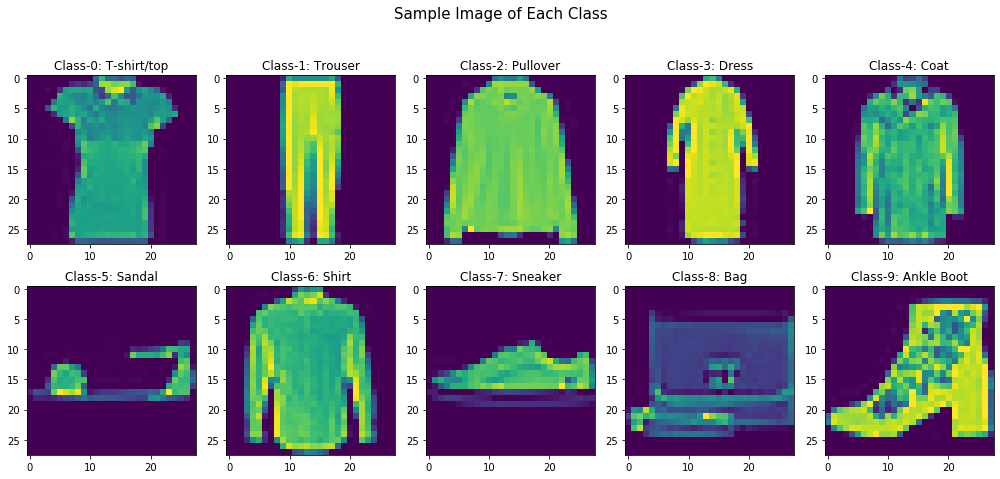

In [156]:
label = 0 
fig = plt.figure(figsize=(14,6))
fig.suptitle('Sample Image of Each Class', y=1.1, fontsize=15)

for i in range(200,400):
    if df_train.iloc[i,0]==label:
        label += 1
        image_data = df_train.iloc[i,1:].tolist()
        image_data_2 = np.zeros((img_rows, img_cols), dtype=np.uint8)
        for index , val in enumerate(image_data):
            row = index // img_rows
            col = index % img_rows 
            image_data_2[row,col] = val
        image = Image.fromarray(image_data_2)
        image = image.resize((img_rows, img_cols))
        ax = fig.add_subplot(2, 5, label)
        plt.title('Class-{}: {}'.format(label-1, df_label.Description[label-1]))
        plt.imshow(image)
        plt.tight_layout()



### 2.B. Image Segmentation  <a class="anchor" id="Img-Seg"></a>

Now that we visualized the images and know how each class looks like, we can further analyze them.
Every digital image is composed of pixels, and pixels form boundaries (curves, lines, etc.) with specific patterns. We can classify the pixels based on their certain characteristics in order to obtain simplified segmentations of an image. The process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects) is called **image segmentation**.  

The result of image segmentation is a set of segments that collectively cover the entire image, or a set of contours extracted from the image. Each of the pixels in a region are similar with respect to some characteristic or computed property, such as color, intensity, or texture. Adjacent regions are significantly different with respect to the same characteristic(s). Image segmentation has a vast area of applications from face detections to medical imaging for locating tumors, etc.

In the following I use an unsupervised learning technique (K-mean algorithm) to show the first 6 segmentations of a random image from train dataset. 

In [158]:
# Visualizing the nth row image:
def visual_pic(n):
    image_data = X[n]
    image_data = image_data.reshape(img_rows,img_cols)
    plt.figure(figsize = (4,4))
    plt.imshow(image_data, cmap='gray')
    plt.show()
 

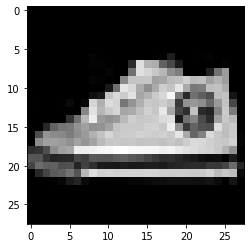

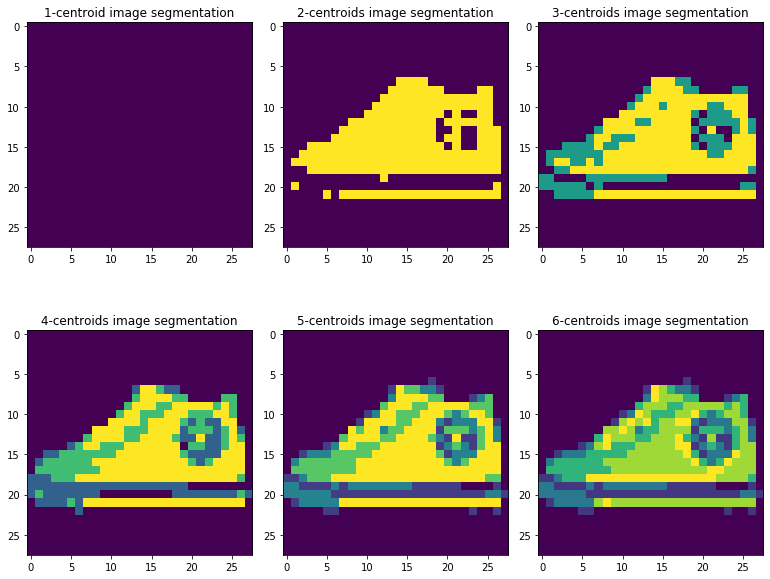

In [162]:
#Pick a random image form train dataset
xx = random.randint(0,60000)
visual_pic(xx)

test_image = X[xx]
test_image = test_image.reshape(img_rows*img_cols, 1)
fig = plt.figure(figsize=(10.8, 10.8))

#i has to start from 1 because n_clusters cannot be 0
for i in range(1,7):
    ax = fig.add_subplot(2, 3, i)
    kmeans_cluster = KMeans(n_clusters = int(i))
    kmeans_cluster.fit(test_image)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_
    plt.imshow(cluster_centers[cluster_labels].reshape(img_rows,img_cols))
    if i==1:
        plt.title("{}-centroid image segmentation".format(i))
    else:
        plt.title("{}-centroids image segmentation".format(i))
    plt.tight_layout()


The original image has been categorized into K-centroid segmented images. The first one (1-centroid) has only one cluster, which means all pixels are classified into one group, thus we have one blank image. By increasing the number of K (centroids) different groups of pixels emerged, so we can see more detailed edges and borders of the image. 


## 3. Multilayer Neural Network  <a class="anchor" id="Neural-Network"></a>

The objective of the fashion-MNIST project is to develop a model that identifies the fashion items –it can be translated into an image classification problem for deep learning models. Recently, such a classification became quite popular as it has a variety of applications and can be approached in many different angles. Subsequently, there has been already numerous studies in this field that build models with accuracy somewhere between 80 to 90+ percent. 

In a nutshell, the goal of *my* project is to find a better model by tweaking the parameters combined with relevant statistical algorithms to enhance the accuracy without a high computational cost.

First, I started with image classification using a basic neural network.


In [116]:
# fix random seed for reproducibility
np.random.seed(8)

In [40]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(img_rows*img_cols,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 8s 168us/step - loss: 0.5568 - acc: 0.7980 - val_loss: 0.4427 - val_acc: 0.8403
Epoch 2/30
48000/48000 [==============================] - 7s 145us/step - loss: 0.4464 - acc: 0.8402 - val_loss: 0.4306 - val_acc: 0.8455
Epoch 3/30
48000/48000 [==============================] - 7s 144us/step - loss: 0.4132 - acc: 0.8517 - val_loss: 0.4316 - val_acc: 0.8488
Epoch 4/30
48000/48000 [==============================] - 5s 94us/step - loss: 0.3936 - acc: 0.8591 - val_loss: 0.4073 - val_acc: 0.8524
Epoch 5/30
48000/48000 [==============================] - 8s 160us/step - loss: 0.3796 - acc: 0.8629 - val_loss: 0.4199 - val_acc: 0.8537
Epoch 6/30
48000/48000 [==============================] - 5s 114us/step - loss: 0.3663 - acc: 0.8686 - val_loss: 0.4512 - val_acc: 0.8032
Epoch 7/30
48000/48000 [==============================] - 6s 118us/step - loss: 0.3559 - acc: 0.8699 - val_loss: 0.3946 - v

Let's begin by choosing how we want to build our model; the `Sequential` model which is a linear stack of layers is a good choice (another option is `functional` which is good for defining a complex model with multiple inputs and/or outputs or a model with shared layers).
The first layer has 100 nodes and takes the input features and `add`s it to the network. In a neural network, we would update the weights and biases of the neurons on the basis of the error at the output. Activation functions make this process (back-propagation) possible as it decides, whether a neuron should be activated or not by calculating a weighted sum and further adding bias with it.
The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks. A neural network without an activation function is essentially just a linear regression model. 

For the first two layers ReLU activation function is used –it is a linear function for all positive values, and zero for all negative values. The last layer has 10 nodes corresponding to the 10 classes in our dataset and uses the Softmax activation function that returns their probabilities. 

Once the model is built we can configure its learning process with `.compile()`. Since our target (y) is converted to catagorical values we use `categorical_crossentropy` loss function. An optimizer is the second required argument for compilation; here I used stochastic gradient descent (SGD) optimizer with a learning rate of 0.05 and momentum of 0.9 (to accelerate SGD in the relevant direction and dampens oscillations).

Training is performed for 30 epochs and the test set is evaluated at the end of each epoch so that we can plot learning curves at the end of the run.

In [41]:
model.evaluate(X_test, y_test)


10000/10000 [==============================] - 0s 41us/step


[0.42574366126060487, 0.8599]

In the model above, Test loss is `0.42574366126060487` and Test accuracy is `0.8599`!

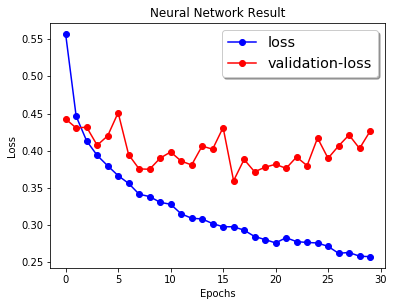

In [42]:
fig = plt.figure(figsize=(6,4.5))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'], 'ob-', label='loss')
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'], 'or-', label='validation-loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Neural Network Result')

plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()


### 3.A. Hyperparameter Tuning  <a class="anchor" id="Tuning"></a>

The neural network has many parameters and tuning these parameters and using the right ones could enhance the performance of a model. However, since the number of parameters is very large, it is quite difficult to configure all of them at once. In scikit-learn the hyperparameter optimization is provided in `GridSearchCV` class. Here we will employ the same technique to grid search and find *some* of the best parameters for our neural network model. 
It is worth mentioning adding more parameters to the grid search, exponentially increases the calculation time. Thus, I only grid searched for the optimizer and activation functions. 

Keras models can be used in scikit-learn by wrapping them with the `KerasClassifier` or `KerasRegressor` class.

In [45]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='relu'):    
    model = Sequential()
    model.add(Dense(100, activation=activation, input_shape=(img_rows*img_cols,)))
    model.add(Dense(50, activation=activation))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


#Create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10)


#Define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#epochs = [10,20,30]

param_grid = dict(optimizer=optimizer, activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_test, y_test, verbose=1)

C:\Users\shiva\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/10
10000/10000 [==============================] - 3s 283us/step - loss: 0.6286 - acc: 0.7800
Epoch 2/10
10000/10000 [==============================] - 2s 228us/step - loss: 0.4503 - acc: 0.8429
Epoch 3/10
10000/10000 [==============================] - 2s 227us/step - loss: 0.4070 - acc: 0.8573
Epoch 4/10
10000/10000 [==============================] - 2s 228us/step - loss: 0.3797 - acc: 0.8675
Epoch 5/10
10000/10000 [==============================] - 2s 225us/step - loss: 0.3580 - acc: 0.8719
Epoch 6/10
10000/10000 [==============================] - 2s 230us/step - loss: 0.3445 - acc: 0.8788
Epoch 7/10
10000/10000 [==============================] - 2s 228us/step - loss: 0.3309 - acc: 0.8848
Epoch 8/10
10000/10000 [==============================] - 2s 230us/step - loss: 0.3197 - acc: 0.8880
Epoch 9/10
10000/10000 [==============================] - 2s 227us/step - loss: 0.3095 - acc: 0.8902
Epoch 10/10
10000/10000 [==============================] - 2s 231us/step - loss: 0.3002 - a

In [50]:
#Summarize results
print('Best score: {} Best params: {}'.format(grid_result.best_score_, grid_result.best_params_))

Best score: 0.8583999933302402 Best params: {'activation': 'tanh', 'optimizer': 'Adagrad'}


This took a while (only for 3 fold cross validation), but at least we got the two parameters; the best activation is `tanh` and the best optimizer is `Adagrad`!

Now, the next step is to replace these parameters in the model (above) and see how well it gets.

In [24]:
model_2 = Sequential()
model_2.add(Dense(100, activation='tanh', input_shape=(img_rows*img_cols,)))
model_2.add(Dense(50, activation='tanh'))
model_2.add(Dense(10, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
hist_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 12s 242us/step - loss: 0.4966 - acc: 0.8238 - val_loss: 0.4100 - val_acc: 0.8538
Epoch 2/30
48000/48000 [==============================] - 12s 258us/step - loss: 0.3883 - acc: 0.8592 - val_loss: 0.3814 - val_acc: 0.8612
Epoch 3/30
48000/48000 [==============================] - 5s 107us/step - loss: 0.3613 - acc: 0.8709 - val_loss: 0.3651 - val_acc: 0.8685
Epoch 4/30
48000/48000 [==============================] - 5s 96us/step - loss: 0.3438 - acc: 0.8776 - val_loss: 0.3653 - val_acc: 0.8658
Epoch 5/30
48000/48000 [==============================] - 4s 85us/step - loss: 0.3319 - acc: 0.8806 - val_loss: 0.3424 - val_acc: 0.8783
Epoch 6/30
48000/48000 [==============================] - 5s 113us/step - loss: 0.3211 - acc: 0.8858 - val_loss: 0.3459 - val_acc: 0.8731
Epoch 7/30
48000/48000 [==============================] - 4s 79us/step - loss: 0.3129 - acc: 0.8879 - val_loss: 0.3334 - v

In [43]:
model_2.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 42us/step


[0.30484951930046084, 0.89]

So, Test loss is `0.30484951930046084` and Test accuracy is `0.89`, which is about less than 1% better that what is was previously (`0.8599`). Not quite impressive considering the time we spent to find the two parameters.
In the next part, we switch gears to the convolutional nueurl network (CNN) model.

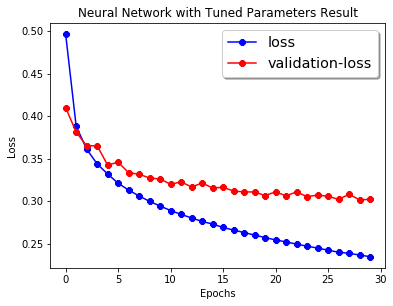

In [44]:
fig = plt.figure(figsize=(6,4.5))
plt.plot(range(len(hist_2.history['loss'])), hist_2.history['loss'], '8b-', label='loss')
plt.plot(range(len(hist_2.history['val_loss'])), hist_2.history['val_loss'], '8r-', label='validation-loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Neural Network with Tuned Parameters Result')

plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()


## 4. Convolutional Neural Network  <a class="anchor" id="CNN"></a>

A convolutional neural network (CNN) is a neural network that has at least one conventional layer.
Analogous to the neural network which is inspired by a human brain, in CNN the connectivity pattern between neurons resembles the organization of the human/animal visual cortex.
The convolutional layer applies the convolution with a learnable filter (kernel), as a result the network learns the patterns in the images: edges, corners, arcs, then more complex figures. 
Such layer receives its input from multiple units from the previous layer which together create a proximity. Therefore, the input units (that form a small neighborhood) share their weights.

Each convolutional layer within a neural network should have the following attributes:
- Input is a tensor with shape (number of images) x (image width) x (image height) x (image depth).
- Convolutional kernels whose width and height are hyperparameters, and whose depth must be equal to that of the image. Convolutional layers convolve the input and pass its result to the next layer. This is similar to the response of a neuron in the visual cortex to a specific stimulus.

Let's start building our first CNN model `cnn_1`: 
- The first important step is to reshape the input, which is a (number-of-images) x 28 x 28 x 1 array of pixel values. Image depth is 1 because they are gray scale.
- The first layer in a CNN is always a convolutional layer. The kernel size refers to the width x height of the filter mask. `padding='same'` adds the required padding to the input image to ensure that the output has the same shape as the input, and `strides=1` means the kernel is moved by 1 as it passes over the image. These two eliminate losing information on corners of images.
- `MaxPooling2D` reduces the dimensions of the image by combining the outputs of neuron clusters at one layer into a single neuron in the next layer (down-sampling).
- A fully connected layer occupies most of the parameters, thus it is prone to overfitting. One method to reduce overfitting is `Dropout`, in which individual nodes are either *dropped out* of the net with probability 1-p or kept with probability p, so that a reduced network is left.
- Finally, before passing our pooled feature map to the neural network (the next step), we need to convert it into a column like data by using `Flatten()`.
- The last step is a layer of 10 nodes for classifying our 10 calss output.
- Now, we can compile the model.
- A `callback` is added to the `fit` step in order to monitor validation accuracy to eliminate overtraining (it stops training when the monitored quantity has stopped improving).

In [163]:
# Reshaping the data for CNN
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [164]:
cnn_1 = Sequential()
cnn_1.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
                 input_shape=input_shape, padding='same', strides=1))
cnn_1.add(MaxPooling2D(pool_size=(2,2)))
cnn_1.add(Dropout(0.2))
cnn_1.add(Flatten())
cnn_1.add(Dense(100, activation='relu'))
cnn_1.add(Dense(10, activation='softmax'))

cnn_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
batch_size=128 
train = cnn_1.fit(X_train, y_train, batch_size=batch_size,
                  epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 51s 944us/step - loss: 0.4771 - acc: 0.8308 - val_loss: 0.3665 - val_acc: 0.8687
Epoch 2/30
54000/54000 [==============================] - 27s 505us/step - loss: 0.3289 - acc: 0.8822 - val_loss: 0.3077 - val_acc: 0.8918
Epoch 3/30
54000/54000 [==============================] - 28s 523us/step - loss: 0.2873 - acc: 0.8969 - val_loss: 0.2957 - val_acc: 0.8927
Epoch 4/30
54000/54000 [==============================] - 27s 504us/step - loss: 0.2603 - acc: 0.9070 - val_loss: 0.2723 - val_acc: 0.9008
Epoch 5/30
54000/54000 [==============================] - 28s 516us/step - loss: 0.2394 - acc: 0.9127 - val_loss: 0.2582 - val_acc: 0.9075
Epoch 6/30
54000/54000 [==============================] - 28s 518us/step - loss: 0.2220 - acc: 0.9180 - val_loss: 0.2562 - val_acc: 0.9068
Epoch 7/30
54000/54000 [==============================] - 35s 648us/step - loss: 0.2072 - acc: 0.9241 - val_loss: 0.2

In [165]:
cnn_1.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 311us/step


[0.25286955044865606, 0.9181]

In [166]:
cnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_129 (Flatten)        (None, 6272)              0         
_________________________________________________________________
dense_290 (Dense)            (None, 100)               627300    
_________________________________________________________________
dense_291 (Dense)            (None, 10)                1010      
Total params: 628,630
Trainable params: 628,630
Non-trainable params: 0
_________________________________________________________________


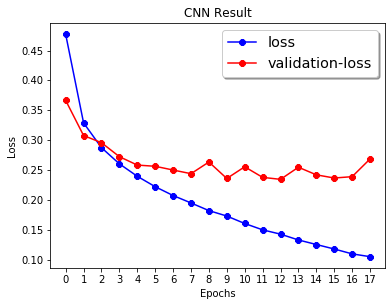

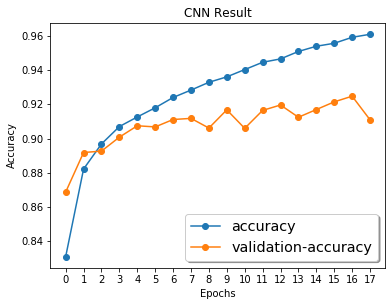

In [167]:
fig = plt.figure(figsize=(6,4.5))
plt.plot(range(len(train.history['loss'])), train.history['loss'], '8b-', label='loss')
plt.plot(range(len(train.history['val_loss'])), train.history['val_loss'], '8r-', label='validation-loss')
plt.xticks(range(len(train.history['loss'])))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Result')

plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

fig = plt.figure(figsize=(6,4.5))
plt.plot(range(len(train.history['acc'])), train.history['acc'], 'o-', label='accuracy')
plt.plot(range(len(train.history['val_acc'])), train.history['val_acc'], 'o-', label='validation-accuracy')
plt.xticks(range(len(train.history['loss'])))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Result')

plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()


### 4.A. Image Augmentation  <a class="anchor" id="Img-Aug"></a>

Arguably, the data which is used during the training step plays the most important role in the accuracy of a model. In fact, the performance of the neural networks improves with the amount of data available. 
In our model, in order to to (artificially) expand the size of the training dataset we can create modified versions of images in the dataset; this is a well-known technique, called image augmentation. The purpose of image augmentation is to not only increase the quantity of the dataset, but also to enrich its diversity. This method generates transformed versions of images in the training dataset that belong to the same class as the original image. The transformation includes a range of operations from the field of image manipulation, such as shifts, flips, zooms, etc. 


`ImageDataGenerator` class provides the ability to use data augmentation automatically when training a model.
Here I used the following arguments for building new training and validation datasets:
- `rotation_range` for rotating images
- `width_shift_range` and `height_shift_range` for shifting images
- `shear_range` for shearing the images (in counter-clockwise direction in degrees)
- Image zoom via the `zoom_range` argument

The train and validation generator is created by `.flow()` which can be used to train our model by calling the `fit_generator()` function. `steps_per_epoch indicates` indicates how many times a new batch is fetched from the generator during single epoch. 

In [168]:
train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, height_shift_range=0.08, 
                               shear_range=0.3, zoom_range=0.08)
val_gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,  height_shift_range=0.01,
                              shear_range=0.1, zoom_range=0.02)

train_generator = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_gen.flow(X_val, y_val, batch_size=batch_size)

In [169]:
train_aug = cnn_1.fit_generator(train_generator, validation_data = val_generator, 
                                   steps_per_epoch = len(X_train)//batch_size,
                                   validation_steps = len(X_val)//batch_size,
                                   epochs=30, callbacks=callbacks)

Epoch 1/30
421/421 [==============================] - 44s 104ms/step - loss: 0.4473 - acc: 0.8333 - val_loss: 1.0066 - val_acc: 0.6841
Epoch 2/30
421/421 [==============================] - 39s 93ms/step - loss: 0.3791 - acc: 0.8578 - val_loss: 1.0068 - val_acc: 0.6756
Epoch 3/30
421/421 [==============================] - 38s 90ms/step - loss: 0.3593 - acc: 0.8665 - val_loss: 0.9611 - val_acc: 0.7037
Epoch 4/30
421/421 [==============================] - 38s 91ms/step - loss: 0.3444 - acc: 0.8710 - val_loss: 0.9219 - val_acc: 0.7028
Epoch 5/30
421/421 [==============================] - 38s 90ms/step - loss: 0.3389 - acc: 0.8724 - val_loss: 0.9096 - val_acc: 0.7069
Epoch 6/30
421/421 [==============================] - 38s 89ms/step - loss: 0.3255 - acc: 0.8781 - val_loss: 0.9177 - val_acc: 0.7108
Epoch 7/30
421/421 [==============================] - 39s 92ms/step - loss: 0.3192 - acc: 0.8799 - val_loss: 0.9591 - val_acc: 0.6962
Epoch 8/30
421/421 [==============================] - 38s 91m

In [170]:
cnn_1.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 300us/step


[0.2269003446608782, 0.9212]

The result looks better; accuray is improved to `0.9212`!


### 4.B. KFold Cross-Validation <a class="anchor" id="cv"></a>

In the previous sections, we built two models (`model` and `cnn_1`) by splitting our data into training and validation sets. The training set is used to train the model, and the validation set is used to validate it on the data that the model has never seen before (the split is 80%-20%). 

With such a split the accuracy is high during the training process, however, it usually fails when it tests the test dataset. This is because through training the model tries to be be exact and includes all the noises of the training dataset, then it is validated on a small validation subset, and at the end when it sees a new big test dataset due to its variability the model does not do as well.
This is a typical overfitting problem.

One way to overcome this problem is to diversify the dataset as much as possible (as I explained in image augmentation section), another way is to **not** use the entire dataset when training the learner. As such, some of the data is removed before training begins. Then when training is done, the data that was removed can be used to test the performance of the learned model on the *new* data. This is the basic idea for a whole class of model evaluation methods called **cross validation**. 

In cross validation the dataset is divided into k equal size subsets. One of the k subsets is retained as the validation data for testing the model, and the remaining k-1 subsubsets are used as training data. This process is then repeated k times, with each of the k subsets used exactly once as the validation data. 

Below, I utilized this strategy to yet improve our model; first I create a `molde_eval` function with the exact same parameters as the original `cnn_1`. Then I make a 10-fold split of the data which will be fed to the `model_eval` 10 times. In each iteration the model is generating the best weight and saves that as the initial weight for the next iteration. 

The first `cnn_kf` model splits the train detaset into 10 consecutive folds in which every sample is in one and only one fold. The next `cnn_rs` is also dividing the train dataset to 10 subsets, but instead of 10 folds containing only once-participating samples here we take random permutation of them.

In [188]:
def model_eval(X_train, X_val, y_train, y_val):
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
                   input_shape=input_shape, padding='same', strides=1))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Dropout(0.2))
    cnn.add(Flatten())
    cnn.add(Dense(100, activation='relu'))
    cnn.add(Dense(10, activation='softmax'))

    file = pathlib.Path('weight.hdf5')
    if file.exists():
        cnn.load_weights('weight.hdf5')
    
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('weight.hdf5', monitor='val_acc', mode='auto',
                                 save_best_only=True, save_weights_only=False)    
    callbacks = EarlyStopping(monitor='val_loss', patience=10)
    
    train = cnn.fit(X_train, y_train, batch_size=128, 
                    epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint, callbacks], verbose=1)
    
    _, val_acc = cnn.evaluate(X_val, y_val, verbose=1)

    return cnn, val_acc, train



In [194]:
kf = KFold(n_splits=10, random_state=103)
kf.get_n_splits(X)
cv_scores, model_history, train_history = list(), list(), list()
X = X.reshape(X.shape[0], img_rows, img_cols, 1)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # evaluate model
    cnn_kf, val_acc, train = model_eval(X_train, X_val, y_train, y_val)
    print('>%.3f' % val_acc)
    cv_scores.append(val_acc)
    model_history.append(cnn_kf)
    train_history.append(train)
    
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))



Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 44s 809us/step - loss: 0.0374 - acc: 0.9861 - val_loss: 0.0216 - val_acc: 0.9935
Epoch 2/30
54000/54000 [==============================] - 31s 566us/step - loss: 0.0354 - acc: 0.9871 - val_loss: 0.0299 - val_acc: 0.9890
Epoch 3/30
54000/54000 [==============================] - 31s 569us/step - loss: 0.0354 - acc: 0.9873 - val_loss: 0.0325 - val_acc: 0.9883
Epoch 4/30
54000/54000 [==============================] - 31s 566us/step - loss: 0.0325 - acc: 0.9885 - val_loss: 0.0325 - val_acc: 0.9895
Epoch 5/30
54000/54000 [==============================] - 33s 608us/step - loss: 0.0273 - acc: 0.9904 - val_loss: 0.0276 - val_acc: 0.9905
Epoch 6/30
54000/54000 [==============================] - 32s 589us/step - loss: 0.0329 - acc: 0.9889 - val_loss: 0.0319 - val_acc: 0.9878
Epoch 7/30
54000/54000 [==============================] - 31s 582us/step - loss: 0.0308 - acc: 0.9886 - val_loss: 0.0

6000/6000 [==============================] - 2s 408us/step
>0.988
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 44s 823us/step - loss: 0.0329 - acc: 0.9883 - val_loss: 0.0148 - val_acc: 0.9960
Epoch 2/30
54000/54000 [==============================] - 28s 525us/step - loss: 0.0271 - acc: 0.9904 - val_loss: 0.0149 - val_acc: 0.9958
Epoch 3/30
54000/54000 [==============================] - 28s 522us/step - loss: 0.0301 - acc: 0.9895 - val_loss: 0.0167 - val_acc: 0.9952
Epoch 4/30
54000/54000 [==============================] - 28s 525us/step - loss: 0.0299 - acc: 0.9898 - val_loss: 0.0189 - val_acc: 0.9932
Epoch 5/30
54000/54000 [==============================] - 28s 518us/step - loss: 0.0247 - acc: 0.9915 - val_loss: 0.0211 - val_acc: 0.9927
Epoch 6/30
54000/54000 [==============================] - 28s 524us/step - loss: 0.0289 - acc: 0.9895 - val_loss: 0.0269 - val_acc: 0.9907
Epoch 7/30
54000/54000 [===========================

54000/54000 [==============================] - 33s 603us/step - loss: 0.0210 - acc: 0.9929 - val_loss: 0.0184 - val_acc: 0.9942
Epoch 10/30
54000/54000 [==============================] - 33s 611us/step - loss: 0.0195 - acc: 0.9932 - val_loss: 0.0316 - val_acc: 0.9892
Epoch 11/30
6000/6000 [==============================] - 3s 430us/step
>0.993
Estimated Accuracy 0.988 (0.002)


In [195]:
cnn_kf.evaluate(X_test, y_test)

10000/10000 [==============================] - 5s 502us/step


[0.4001106730127707, 0.927]

In [192]:
rs = ShuffleSplit(n_splits=10, random_state=103,  test_size=0.25)
rs.get_n_splits(X)
cv_scores, model_history, train_history = list(), list(), list()
X = X.reshape(X.shape[0], img_rows, img_cols, 1)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # evaluate model
    cnn_rs, val_acc_rs, train_rs = model_eval(X_train, X_val, y_train, y_val)
    print('>%.3f' % val_acc)
    cv_scores.append(val_acc_rs)
    model_history.append(cnn_rs)
    train_history.append(train_rs)
    
print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))



Train on 56000 samples, validate on 4000 samples
Epoch 1/30
56000/56000 [==============================] - 46s 822us/step - loss: 0.4832 - acc: 0.8293 - val_loss: 0.3441 - val_acc: 0.8780
Epoch 2/30
56000/56000 [==============================] - 33s 594us/step - loss: 0.3247 - acc: 0.8846 - val_loss: 0.2882 - val_acc: 0.8980
Epoch 3/30
56000/56000 [==============================] - 33s 595us/step - loss: 0.2859 - acc: 0.8983 - val_loss: 0.2589 - val_acc: 0.9087
Epoch 4/30
56000/56000 [==============================] - 34s 602us/step - loss: 0.2555 - acc: 0.9087 - val_loss: 0.2624 - val_acc: 0.9040
Epoch 5/30
56000/56000 [==============================] - 33s 591us/step - loss: 0.2367 - acc: 0.9140 - val_loss: 0.2461 - val_acc: 0.9065
Epoch 6/30
56000/56000 [==============================] - 33s 593us/step - loss: 0.2189 - acc: 0.9199 - val_loss: 0.2431 - val_acc: 0.9110
Epoch 7/30
56000/56000 [==============================] - 34s 612us/step - loss: 0.2035 - acc: 0.9258 - val_loss: 0.2

56000/56000 [==============================] - 56s 1ms/step - loss: 0.0831 - acc: 0.9698 - val_loss: 0.0745 - val_acc: 0.9780
Epoch 2/30
56000/56000 [==============================] - 33s 585us/step - loss: 0.0748 - acc: 0.9732 - val_loss: 0.0726 - val_acc: 0.9725
Epoch 3/30
56000/56000 [==============================] - 34s 610us/step - loss: 0.0716 - acc: 0.9742 - val_loss: 0.0799 - val_acc: 0.9702
Epoch 4/30
56000/56000 [==============================] - 32s 578us/step - loss: 0.0661 - acc: 0.9761 - val_loss: 0.0757 - val_acc: 0.9738
Epoch 5/30
56000/56000 [==============================] - 32s 570us/step - loss: 0.0628 - acc: 0.9771 - val_loss: 0.0818 - val_acc: 0.9738
Epoch 6/30
56000/56000 [==============================] - 36s 639us/step - loss: 0.0608 - acc: 0.9774 - val_loss: 0.0864 - val_acc: 0.9712
Epoch 7/30
56000/56000 [==============================] - 30s 539us/step - loss: 0.0539 - acc: 0.9806 - val_loss: 0.0985 - val_acc: 0.9643
Epoch 8/30
56000/56000 [================

56000/56000 [==============================] - 31s 559us/step - loss: 0.0399 - acc: 0.9857 - val_loss: 0.0934 - val_acc: 0.9647
Epoch 12/30
4000/4000 [==============================] - 2s 375us/step
>0.982
Train on 56000 samples, validate on 4000 samples
Epoch 1/30
56000/56000 [==============================] - 43s 776us/step - loss: 0.0618 - acc: 0.9774 - val_loss: 0.0427 - val_acc: 0.9868
Epoch 2/30
56000/56000 [==============================] - 31s 555us/step - loss: 0.0606 - acc: 0.9774 - val_loss: 0.0508 - val_acc: 0.9808
Epoch 3/30
56000/56000 [==============================] - 32s 566us/step - loss: 0.0544 - acc: 0.9795 - val_loss: 0.0470 - val_acc: 0.9832
Epoch 4/30
56000/56000 [==============================] - 31s 560us/step - loss: 0.0516 - acc: 0.9819 - val_loss: 0.0507 - val_acc: 0.9828
Epoch 5/30
56000/56000 [==============================] - 32s 563us/step - loss: 0.0489 - acc: 0.9822 - val_loss: 0.0612 - val_acc: 0.9770
Epoch 6/30
56000/56000 [==========================

56000/56000 [==============================] - 32s 573us/step - loss: 0.0353 - acc: 0.9871 - val_loss: 0.0485 - val_acc: 0.9810
Epoch 9/30
56000/56000 [==============================] - 31s 562us/step - loss: 0.0360 - acc: 0.9874 - val_loss: 0.0563 - val_acc: 0.9828
Epoch 10/30
56000/56000 [==============================] - 32s 563us/step - loss: 0.0321 - acc: 0.9881 - val_loss: 0.0628 - val_acc: 0.9790
Epoch 11/30
56000/56000 [==============================] - 32s 574us/step - loss: 0.0313 - acc: 0.9887 - val_loss: 0.0583 - val_acc: 0.9785
Epoch 12/30
4000/4000 [==============================] - 2s 392us/step
>0.982
Train on 56000 samples, validate on 4000 samples
Epoch 1/30
56000/56000 [==============================] - 44s 793us/step - loss: 0.0467 - acc: 0.9829 - val_loss: 0.0248 - val_acc: 0.9925
Epoch 2/30
56000/56000 [==============================] - 32s 566us/step - loss: 0.0405 - acc: 0.9857 - val_loss: 0.0360 - val_acc: 0.9880
Epoch 3/30
56000/56000 [========================

In [193]:
cnn_rs.evaluate(X_test, y_test)

10000/10000 [==============================] - 5s 484us/step


[0.3515950898159295, 0.929]

The result is much better than the original `cnn_1` model; the accuracy is almost 93% in Kfold model with shuffle split!


## 5. Classification Report  <a class="anchor" id="Report"></a>

Eventually, we can compare and summarize the performance of our models by checking their predictions. `classification_report` takes the true labels (`y_true`), predicted labels, and the list of target classes and returns the classification metrics;  

- `pecision` is the ratio of correctly predicted positive observations to the total predicted positive observations. 
- `recall` is the ratio of correctly predicted positive observations to the all observations in actual class. 
- `f1-score` is the weighted average of Precision and Recall.
- `support` is the number of samples of the true response that lie in that class.
- `macro avg` and `weighted avg` are unweighted and weighted average of the precision of all the classes (since the number of samples in each class is equal these, two parameters are also equal).



In [256]:
y_true = df_test.iloc[:,0]

y_pred_cnn_1 = cnn_1.predict_classes(X_test)
y_pred_cnn_kf = cnn_kf.predict_classes(X_test)
y_pred_cnn_rs = cnn_rs.predict_classes(X_test)

target_names = ['Class {}: {}'.format(i, df_label.Description[i]) for i in range(10)]

print('{} cnn_1 Report {}\n'.format(24*'=', 24*'='))
print(classification_report(y_true, y_pred_cnn_1, target_names=target_names))
print('{} cnn_kf Report {}\n'.format(23*'=', 23*'='))
print(classification_report(y_true, y_pred_cnn_kf, target_names=target_names))
print('{} cnn_rs Report {}\n'.format(23*'=', 23*'='))
print(classification_report(y_true, y_pred_cnn_rs, target_names=target_names))


======================== cnn_1 Report ========================

                      precision    recall  f1-score   support

Class 0: T-shirt/top       0.90      0.86      0.88      1000
    Class 1: Trouser       0.98      0.99      0.99      1000
   Class 2: Pullover       0.93      0.81      0.87      1000
      Class 3: Dress       0.93      0.93      0.93      1000
       Class 4: Coat       0.86      0.90      0.88      1000
     Class 5: Sandal       0.98      0.99      0.98      1000
      Class 6: Shirt       0.74      0.81      0.78      1000
    Class 7: Sneaker       0.96      0.96      0.96      1000
        Class 8: Bag       0.99      0.99      0.99      1000
 Class 9: Ankle Boot       0.97      0.96      0.97      1000

            accuracy                           0.92     10000
           macro avg       0.92      0.92      0.92     10000
        weighted avg       0.92      0.92      0.92     10000

======================= cnn_kf Report =======================

  

Noticeably the classifiers which are trained by Kfolds cross validation are doing a better job than the first cnn model. Although, class 6 is ~4% improved in `cnn_kf` and `cnn_rs` compared to `cnn_1`, it still has the lowest precision amongst all other classes. 

To better present the predictions, here I plot the confusion matrix of the models. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
x and y axis show the predicted and true labels respectively.


It is apparent that the most common mistake is that class 6 (Shirt) was mislabeled to be class 0 (T-shirt/top) and vice versa. It somehow makes sense as shirts and T-shirts/tops are similar! 

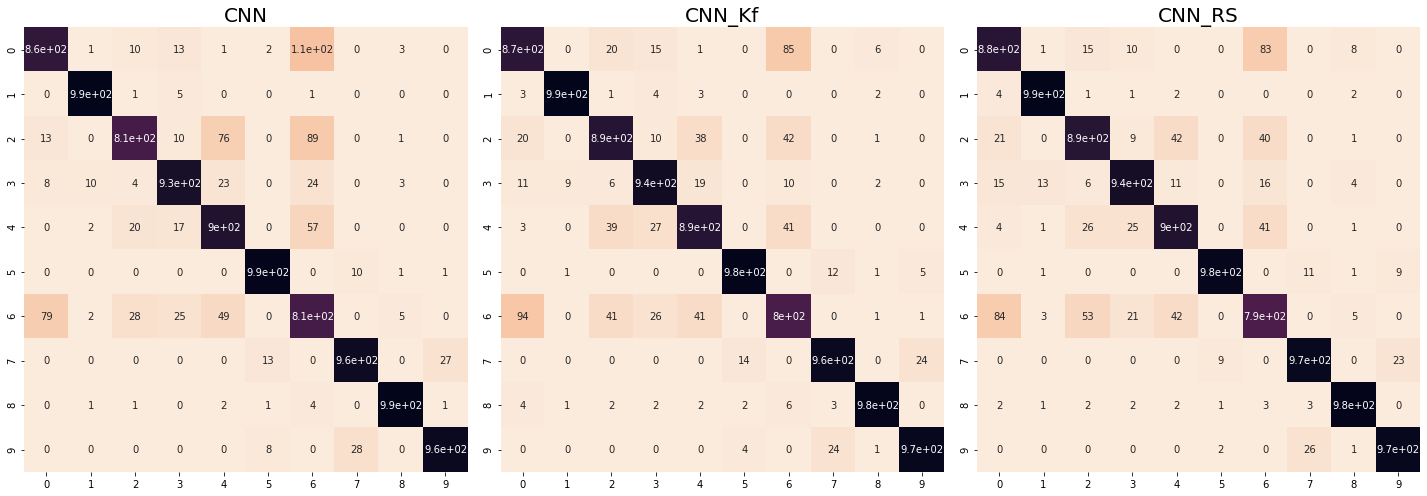

In [308]:
cm_cnn_1 = confusion_matrix(y_true, y_pred_cnn_1)
cm_cnn_kf = confusion_matrix(y_true, y_pred_cnn_kf)
cm_cnn_rs = confusion_matrix(y_true, y_pred_cnn_rs)

plt.figure(figsize = (20,7))
plt.subplot(131)
sns.heatmap(cm_cnn_1, annot=True, cmap=sns.cm.rocket_r, cbar=False)
plt.title('CNN', fontsize=20)
plt.subplot(132)
plt.title('CNN_Kf', fontsize=20)
sns.heatmap(cm_cnn_kf, annot=True, cmap=sns.cm.rocket_r, cbar=False)
plt.subplot(133)
plt.title('CNN_RS', fontsize=20)
sns.heatmap(cm_cnn_rs, annot=True, cmap=sns.cm.rocket_r, cbar=False)
plt.tight_layout() 
plt.show()



In [239]:
correct_1 = np.nonzero(y_pred_cnn_1==y_true)[0]
incorrect_1 = np.nonzero(y_pred_cnn_1!=y_true)[0]

correct_kf = np.nonzero(y_pred_cnn_kf==y_true)[0]
incorrect_kf = np.nonzero(y_pred_cnn_kf!=y_true)[0]

correct_rs = np.nonzero(y_pred_cnn_rs==y_true)[0]
incorrect_rs = np.nonzero(y_pred_cnn_rs!=y_true)[0]

print('The number of incorrect predictions of cnn_1: {}\n\
The number of incorrect predictions of cnn_kf: {}\n\
The number of incorrect predictions of cnn_rs: {}'.format(len(incorrect_1), len(incorrect_kf), len(incorrect_rs)))

The number of incorrect predictions of cnn_1: 788
The number of incorrect predictions of cnn_kf: 730
The number of incorrect predictions of cnn_rs: 710


Let's take a look at a couple of mislabeled images in our models. Below the images with their true label and wrong predictions are shown:


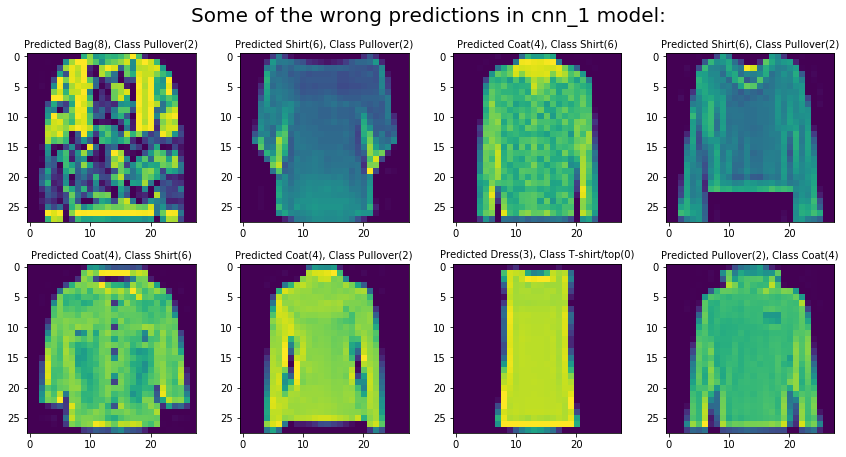

In [263]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Some of the wrong predictions in cnn_1 model:', y=1.05, fontsize=20)
for i, j in enumerate(incorrect_1[0:8]):
    ax = fig.add_subplot(2, 4, i+1)
    plt.imshow(X_test[j].reshape(img_rows, img_cols))
    plt.title("Predicted {}({}), Class {}({})".format(df_label.Description[y_pred_cnn_1[j]],y_pred_cnn_1[j], 
                                              df_label.Description[y_true[j]],y_true[j]), fontsize=10)
    plt.tight_layout()
     


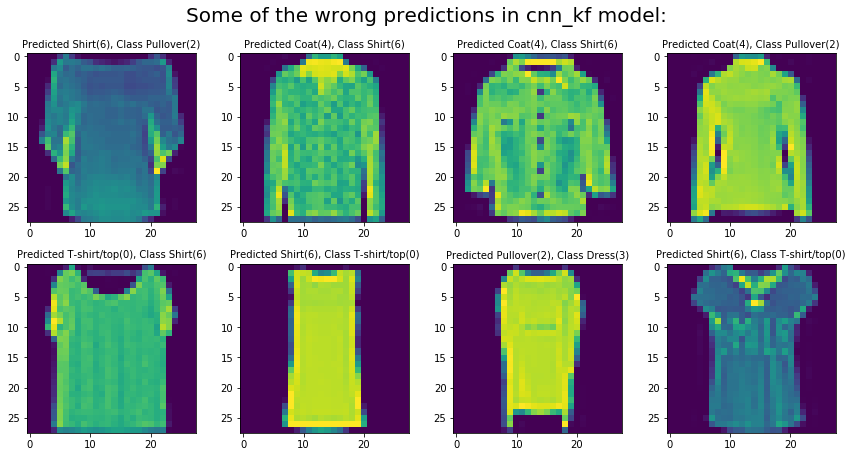

In [264]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Some of the wrong predictions in cnn_kf model:', y=1.05, fontsize=20)

for i, j in enumerate(incorrect_kf[0:8]):
    ax = fig.add_subplot(2, 4, i+1)
    plt.imshow(X_test[j].reshape(img_rows, img_cols))
    plt.title("Predicted {}({}), Class {}({})".format(df_label.Description[y_pred_cnn_kf[j]],y_pred_cnn_kf[j], 
                                              df_label.Description[y_true[j]],y_true[j]), fontsize=10)
    plt.tight_layout()  

By looking at these images it is evident that wrong predictions are inevitable, as some of the images are **SO similar** to many classes at the same time (for instance the third image of the second row above could definitely be a shirt or a dress)!!!


## 6. Visualizing Convolutional Layers  <a class="anchor" id="Conv-Layers"></a>

Finally, let's see what is going on under the hood while we process the images. 
A cnn models, has two major steps: extracting the features which occurs when the images passing through the series of convolution layers (step one), and classifying the images by flattening the output of the convolutional layers and applying the softmax function to classify objects with probabilistic values between 0 and 1.

Convolution an image with different filters can perform operations such as edge detection, blur and sharpen by applying filters.

As the `cnn_1.summary()` shows, the first convolutional layer has 32 channels. In the following figure I show how a random image is convoluted in each of these 32 channels.

In [271]:
cnn_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_129 (Flatten)        (None, 6272)              0         
_________________________________________________________________
dense_290 (Dense)            (None, 100)               627300    
_________________________________________________________________
dense_291 (Dense)            (None, 10)                1010      
Total params: 628,630
Trainable params: 628,630
Non-trainable params: 0
_________________________________________________________________


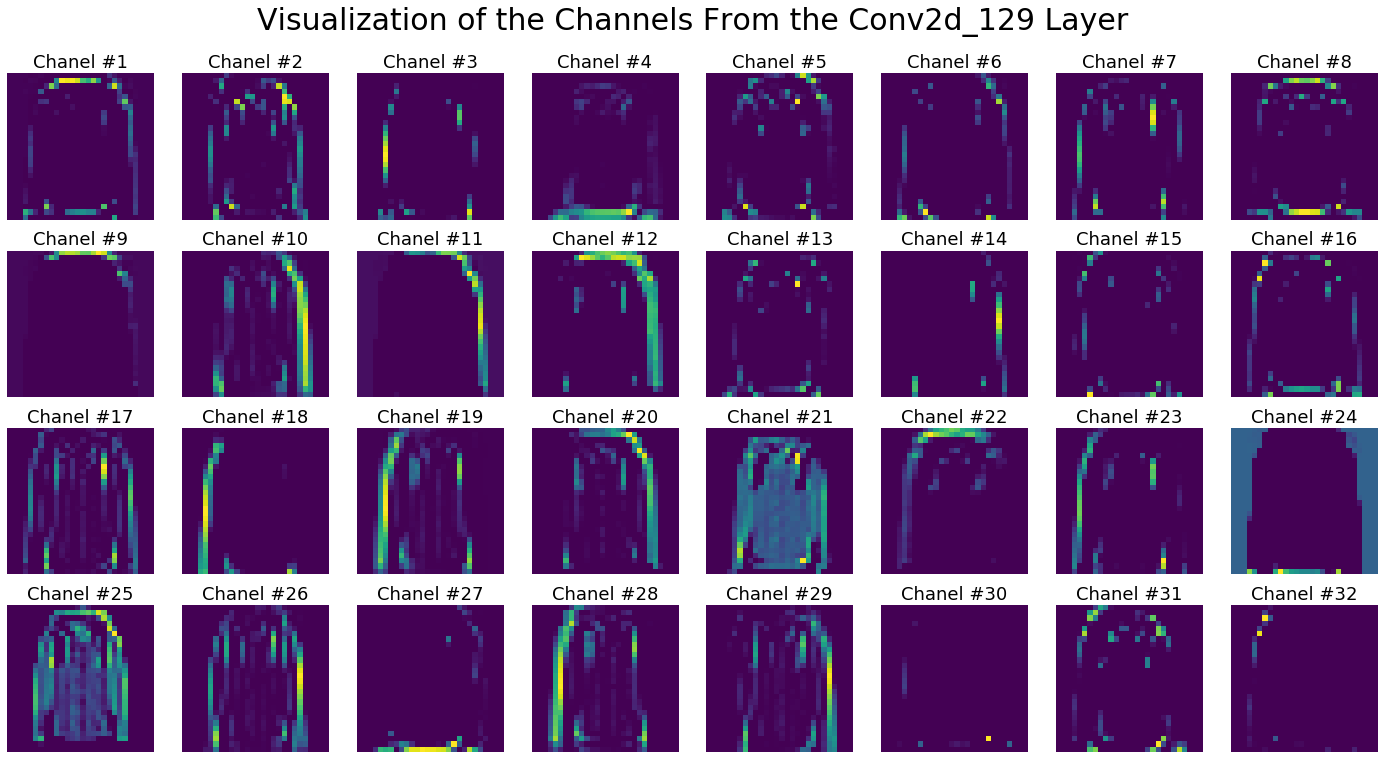

In [274]:
xx = random.randint(0,60000)
test_image = X_train[xx] 
model = cnn_1
which_layer = 0


layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_image.reshape(1, img_rows, img_cols, 1))
activation_layer = activations[which_layer]
num_channels = activation_layer.shape[-1]



fig = plt.figure(figsize=(20,10))
fig.suptitle('Visualization of the Channels From the {} Layer'.
             format((model.layers[which_layer].name).capitalize()),
             y=1.05, fontsize=30)
gs1 = gridspec.GridSpec(20, 10)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(num_channels):
    ax = fig.add_subplot(4, num_channels//4, i+1)
    plt.imshow(activation_layer[0, :, :, i])
    plt.title('Chanel #{}'.format(i+1), fontsize=18)
    plt.axis('off')
    plt.tight_layout()
     